In [1]:
import logging
import time
import os
import pickle
import math

import matplotlib.pyplot as plt

#import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
#import tensorflow_text  # pylint: disable=unused-import
import pandas as pd
import numpy as np
import re
import seaborn as sns

from sklearn.model_selection import train_test_split

import jellyfish 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model,  Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dropout, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Concatenate
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Attention
from tensorflow.keras.optimizers import Adam, Adagrad
from keras.losses import sparse_categorical_crossentropy
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
import random

In [2]:
def AA_Codon_list():
    dic_AA_codon = {'A': ['GCT', 'GCC', 'GCA', 'GCG'],
                    'C': ['TGT', 'TGC'],
                    'D': ['GAT', 'GAC'],
                    'E': ['GAA', 'GAG'],
                    'F': ['TTT', 'TTC'],
                    'G': ['GGT', 'GGA', 'GGC', 'GGG'],
                    'H': ['CAT', 'CAC'],
                    'I': ['ATT', 'ATC', 'ATA'],
                    'K': ['AAA', 'AAG'],
                    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
                    'M': ['ATG'],
                    'N': ['AAT', 'AAC'],
                    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
                    'Q': ['CAA', 'CAG'],
                    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
                    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
                    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
                    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
                    'W': ['TGG'],
                    'Y': ['TAT', 'TAC'],
                    '*': ['TAA', 'TAG', 'TGA']}

    codon_list = []
    AA_list = []
    for key in dic_AA_codon:
        for i in range(len(dic_AA_codon[key])):
            AA_list.append(key)
        for i in dic_AA_codon[key]:
            codon_list.append(i)
    return AA_list, codon_list

def de_tokenize_Codon(sequences):
    AA_list, codon_list = AA_Codon_list()
    keys = codon_list
    values = range(1, len(codon_list) + 1)
    Codon_dict = dict(zip(keys, values))
    seq_de_tokenized = []
    for s in range(len(sequences)):
        seq = sequences[s]
        temp = ''
        for i in range(len(seq) - 1): # Ignore the <END> token
             temp = temp+keys[values.index(seq[i])]
        

        seq_de_tokenized.append(temp)

    return seq_de_tokenized, Codon_dict

In [3]:
AA_list, codon_list = AA_Codon_list()

tokens = {}
cnt = 0
for i in codon_list:
    tokens[i] = str(cnt)
    cnt =cnt+1

In [4]:
Data = pd.read_excel("Test_CodingSequences.xlsx", "Native")
Methods = ['Arch1', 'IDT', 'Genscript', 'Azenta', 'Thermo']
Native_List = ['HSA', 'HGH', 'HGCSF'] 
NonNative_List = ['3B2', 'RBDJ','Her_HC', 'Her_LC']
N_Method = len(Methods)
# N_mol = len()
xticklabels = ['Pichia-CLM'] + Methods[1:]

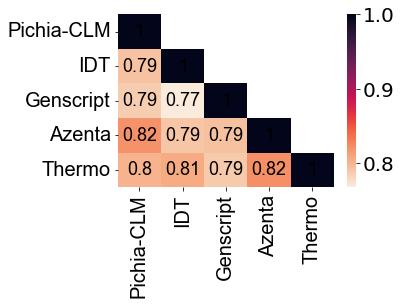

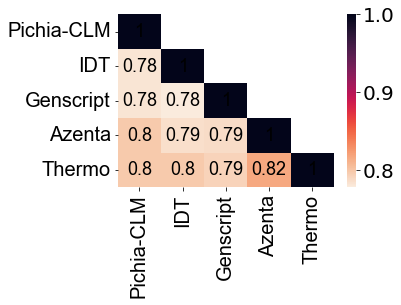

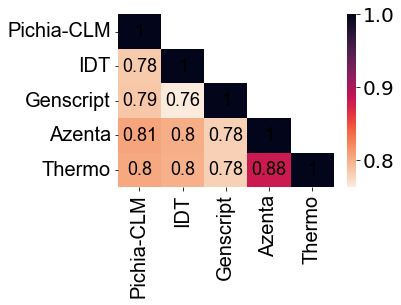

In [5]:
Dist2 = {}
Len2 = {}
Codon_Set = {}
Dist_N = {}
cnt_m = 0
for m in Native_List:
    Dist2[m] = np.zeros((N_Method, N_Method))
    Len2[m] = np.zeros((N_Method,))
    Codon_Set[m] = {} 
    cnt_i = 0
    for i in Methods:
        Sub_data = Data.loc[Data['Architecture']==i][m].values[0]
        Codon_Set[m][i] = [] 
        Len2[m][cnt_i] = len(Sub_data)
        cnt_j = 0
        for j in Methods:
#             print(j)
            Sub_data2 = Data.loc[Data['Architecture']==j][m].values[0]
            
            for l in range(0, int(Len2[m][cnt_i]), 3):
                Codon_Set[m][i].append(Sub_data[l:l+3])
                if Sub_data[l:l+3] == Sub_data2[l:l+3]:
                    Dist2[m][cnt_i,cnt_j] = Dist2[m][cnt_i,cnt_j] + 0
                else:
                    Dist2[m][cnt_i,cnt_j] = Dist2[m][cnt_i,cnt_j] + 1
            cnt_j = cnt_j + 1
        cnt_i = cnt_i + 1

        
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (5,5)

import seaborn as sns

for m in Native_List:
    f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
    plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
    
    plt_data = 1-Dist2[m]/Len2[m].mean() 
    Dist_N[m] = 1 - Dist2[m]/Len2[m].mean() 
    matrix = np.triu(np.ones_like(plt_data))
    np.fill_diagonal(matrix, False)
    
    h_map = sns.heatmap(plt_data, xticklabels= Methods, mask = matrix,
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = Methods,annot=True, fmt='.2g', cmap= sns.color_palette("rocket_r", as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'})
    ax.set_xticklabels(xticklabels, **hfont)
    ax.set_yticklabels(xticklabels, **hfont)
    
    cbar = h_map.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
#     cbar.ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2], **hfont)
#     cbar.ax.set_yticklabels([0, 0.05, 0.1, 0.15, 0.2], **hfont)
    plt.savefig(m+".pdf", dpi = 600, bbox_inches = "tight")

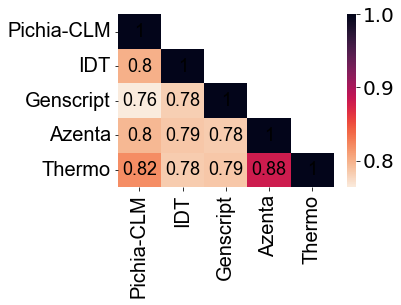

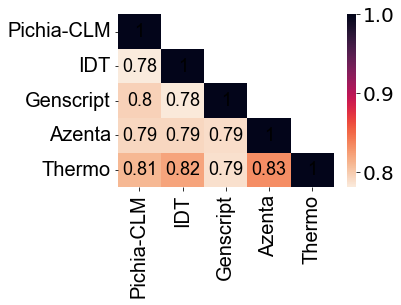

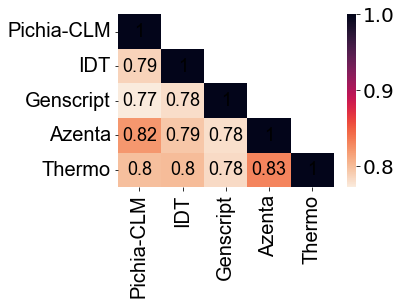

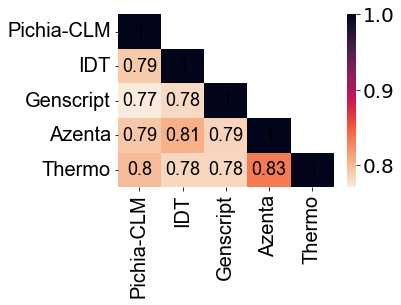

In [6]:
Data = pd.read_excel("Test_CodingSequences.xlsx", "NoNative")
Methods = ['Arch1', 'IDT', 'Genscript', 'Azenta', 'Thermo']
# Native_List = ['HSA', 'HGH', 'HGCSF'] 
NonNative_List = ['3B2', 'RBDJ','Her_HC', 'Her_LC']
N_Method = len(Methods)

xticklabels = ['Pichia-CLM'] + Methods[1:]

Dist2 = {}
Len2 = {}
Dist_NonN = {}
Codon_Set = {}
cnt_m = 0
for m in NonNative_List:
    Dist2[m] = np.zeros((N_Method, N_Method))
    Len2[m] = np.zeros((N_Method,))
    Codon_Set[m] = {} 
    cnt_i = 0
    for i in Methods:
        Sub_data = Data.loc[Data['Architecture']==i][m].values[0]
        Codon_Set[m][i] = [] 
        Len2[m][cnt_i] = len(Sub_data)
        cnt_j = 0
        for j in Methods:
#             print(j)
            Sub_data2 = Data.loc[Data['Architecture']==j][m].values[0]
            
            for l in range(0, int(Len2[m][cnt_i]), 3):
                Codon_Set[m][i].append(Sub_data[l:l+3])
                if Sub_data[l:l+3] == Sub_data2[l:l+3]:
                    Dist2[m][cnt_i,cnt_j] = Dist2[m][cnt_i,cnt_j] + 0
                else:
                    Dist2[m][cnt_i,cnt_j] = Dist2[m][cnt_i,cnt_j] + 1
            cnt_j = cnt_j + 1
        cnt_i = cnt_i + 1

        
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (5,5)

import seaborn as sns

for m in NonNative_List:
    f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
    plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
    Dist_NonN[m] = 1 - Dist2[m]/Len2[m].mean() 
    plt_data = 1-Dist2[m]/Len2[m].mean() 
    matrix = np.triu(np.ones_like(plt_data))
    np.fill_diagonal(matrix, False)
    h_map = sns.heatmap(plt_data, mask = matrix,
                        xticklabels= Methods, #linewidths=2,  linecolor = 'black',
                    yticklabels = Methods,annot=True, fmt='.2g', cmap= sns.color_palette("rocket_r", as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'})
    ax.set_xticklabels(xticklabels, **hfont)
    ax.set_yticklabels(xticklabels, **hfont)
    
    cbar = h_map.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
#     cbar.ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2], **hfont)
#     cbar.ax.set_yticklabels([0, 0.05, 0.1, 0.15, 0.2], **hfont)
    plt.savefig(m+".pdf", dpi = 600, bbox_inches = "tight")

In [7]:
N_mol = len(list(Dist_N.keys())) + len(list(Dist_NonN.keys()))
Agg = np.zeros((5, 5, N_mol))
cnt_k = 0
for k in list(Dist_N.keys()):
    Agg[:, : ,cnt_k] = Dist_N[k]
    cnt_k = cnt_k + 1
for k in list(Dist_NonN.keys()):
    Agg[:, : ,cnt_k] = Dist_NonN[k]
    cnt_k = cnt_k + 1
    
Mean_Agg = np.mean(Agg, axis = 2)
Std_Agg = np.std(Agg, axis = 2)

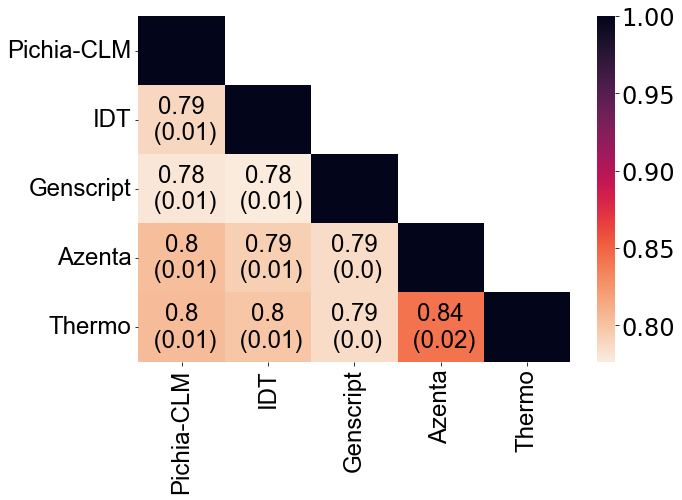

In [10]:
params = {'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24, 'axes.labelsize': 24}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (10,10)

import seaborn as sns

labels = np.empty_like(Mean_Agg, dtype = object)

for i in range(Mean_Agg.shape[0]):
    for j in range(Mean_Agg.shape[0]):
        if np.round(Mean_Agg[i,j],2) == 1:
            labels[i,j] = ' '
        else:
            labels[i,j] = str(np.round(Mean_Agg[i,j],2)) + "\n (" + str(np.round(Std_Agg[i,j],2)) + ")"


f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

matrix = np.triu(np.ones_like(Mean_Agg))

np.fill_diagonal(matrix, False)
h_map = sns.heatmap(Mean_Agg, mask = matrix,
                    xticklabels= Methods, #linewidths=2,  linecolor = 'black',
                yticklabels = Methods,annot=labels, fmt = '',cmap= sns.color_palette("rocket_r", as_cmap=True), #'YlGnBu', 'crest'
            annot_kws = {'fontname': 'Arial', 'fontsize': 24, 'color':'black'}) #fmt='.2g'
ax.set_xticklabels(xticklabels, **hfont)
ax.set_yticklabels(xticklabels, **hfont)

cbar = h_map.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

plt.savefig("Agg_Seq_Similarity.pdf", dpi = 600, bbox_inches = "tight")

In [ ]:
labels = np.round(Mean_Agg, 2)

In [ ]:
labels = np.empty_like(Mean_Agg)

In [ ]:
str(np.round(Mean_Agg[i,j],2)) + "(+/-)" + str(np.round(Std_Agg[i,j],2))

In [ ]:
labels